In [176]:
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont


In [94]:
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

# lets store test passenger id for easy access
PassengerId = test['PassengerId']

In [95]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [96]:
original_train = train.copy()
full_data = [train,test]

In [97]:
#feature that tells wether a passenger has a cabin or not on the titanic
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x : 0 if type(x) == float else 1)

In [98]:
#lets create new feature FamilySize as combinatio of SibSp and Parch
# we are adding one because we count the person also
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

In [99]:
# lets create a feature IsAlone from FamilySize to show solo travellers
train['IsAlone'] = train['FamilySize'].apply(lambda x : 0 if x > 1 else 1)
test['IsAlone'] = test['FamilySize'].apply(lambda x : 0 if x > 1 else 1)

In [100]:
train['Embarked'] = train['Embarked'].fillna('S')
test['Embarked'] = test['Embarked'].fillna('S')

In [101]:
f1 = pd.DataFrame(train['Fare'])
f2 = pd.DataFrame(test['Fare'])
dfm = pd.concat([f1,f2])

In [102]:
median = dfm.median()

In [103]:
train['Fare'] = train['Fare'].fillna(median)
test['Fare'] = test['Fare'].fillna(median)

In [104]:
# comparing dataframes age and finding mean std and null values
a1 = pd.DataFrame(train['Age'])
a2 = pd.DataFrame(test['Age'])
dfage_mean = pd.concat([a1,a2])
age_average = dfage_mean.mean()
age_std = dfage_mean.std()

In [105]:
train_null_size = train['Age'].isnull().sum()
age_null_random_train = np.random.randint(age_average - age_std,age_average + age_std,size = train_null_size )
train.loc[np.isnan(train['Age']),'Age'] = age_null_random_train
train['Age'] = train['Age'].astype('int')

In [106]:
test_null_size = test['Age'].isnull().sum()
age_null_random_test = np.random.randint(age_average - age_std,age_average + age_std,size = test_null_size)
test.loc[np.isnan(test['Age']),'Age'] = age_null_random_test
test['Age'] = test['Age'].astype('int')

In [107]:
# lets define a function that extracts titles from passenger names
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.',name)
    if(title_search):
        return title_search.group(1)
    return ""
    

In [108]:
train['Title'] = train['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)

In [109]:


train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [110]:
test['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [111]:
train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona',],'Rare')

In [112]:
test['Title'] = test['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')

In [113]:
#lets replace the mispelled initial names
train['Title'] = train['Title'].replace('Mlle','Miss')
test['Title'] = test['Title'].replace('Mlle','Miss')

#lets replace the mispelled initial names
train['Title'] = train['Title'].replace('Ms','Miss')
test['Title'] = test['Title'].replace('Ms','Miss')

#lets replace the mispelled initial names
train['Title'] = train['Title'].replace('Mme','Miss')
test['Title'] = test['Title'].replace('Mme','Miss')



In [114]:
train['Sex'] = train['Sex'].map({'male':1,'female':0}).astype(int)

In [115]:
test['Sex'] = test['Sex'].map({'male':1,'female':0}).astype(int)

In [116]:
title_mapping = {'Mr':1,'Master':2,'Mrs':3,'Miss':4,'Rare':5}
train['Title'] = train['Title'].map(title_mapping)
test['Title'] = test['Title'].map(title_mapping)

In [117]:
train['Embarked'] = train['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
test['Embarked'] = test['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)

In [118]:
#mapping fare
train.loc[train['Fare'] <= 7.91,'Fare'] = 0
test.loc[test['Fare'] <= 7.91,'Fare'] = 0

train.loc[(train['Fare'] > 7.91) & (train['Fare'] <= 14.454),'Fare'] = 1
test.loc[(test['Fare'] > 7.91) & (test['Fare'] <= 14.454),'Fare'] = 1

train.loc[(train['Fare'] > 14.454) & (train['Fare'] <= 31),'Fare'] = 2
test.loc[(test['Fare'] > 14.454) & (test['Fare'] <= 31),'Fare'] = 2

train.loc[train['Fare'] > 31,'Fare'] = 3
test.loc[test['Fare'] > 31,'Fare'] = 3

In [119]:
train['Fare'] = train['Fare'].astype('int')
test['Fare'] = test['Fare'].fillna(0)
test['Fare'] = test['Fare'].astype('int')

In [120]:
train.loc[train['Age'] <= 16,'Age'] = 0
test.loc[test['Age'] <= 16,'Age'] = 0
train.loc[train['Age'] > 64,'Age'] = 4
test.loc[test['Age'] > 64,'Age'] = 4

train.loc[(train['Age'] > 16) & (train['Age'] <= 32),'Age'] = 1
test.loc[(test['Age'] > 16) & (test['Age'] <= 32),'Age'] = 1

train.loc[(train['Age'] > 32) & (train['Age'] <= 48),'Age'] = 2
test.loc[(test['Age'] > 32) & (test['Age'] <= 48),'Age'] = 2

train.loc[(train['Age'] > 48) & (train['Age'] <= 64),'Age'] = 3
test.loc[(test['Age'] > 48) & (test['Age'] <= 64),'Age'] = 3

In [122]:
train = train.drop(columns = ['PassengerId','Name','SibSp','Cabin','Ticket'])
test = test.drop(columns = ['PassengerId','Name','SibSp','Cabin','Ticket'])


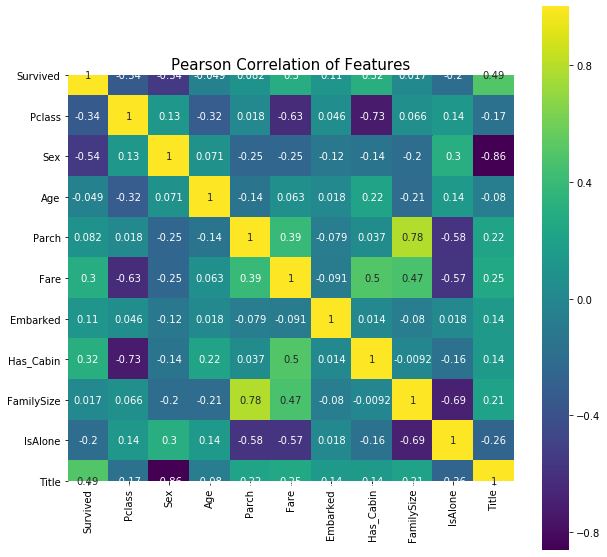

In [140]:
plt.figure(figsize = (10,10))
plt.title('Pearson Correlation of Features',size = 15,y=1)
sns.heatmap(train.astype('float').corr(),cmap='viridis',square = True,annot=True)

In [154]:
# lets analyse title and survived
train[['Title','Survived']].groupby(['Title'],as_index = False).agg(['mean','count','sum'])

# mean gives survival rate,count gives total observations,and sum gives people sorvived

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.792000   125   99
4      0.704301   186  131
5      0.347826    23    8

In [153]:
train[['Sex','Survived']].groupby(['Sex']).agg(['mean','count','sum'])

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

In [156]:
title_and_sex = original_train.copy()[['Name','Sex']]

In [158]:
title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

In [161]:
title_and_sex['Sex'] = title_and_sex['Sex'].map({'female':0,'male':1}).astype('int')

In [163]:
title_and_sex[['Title','Sex']].groupby(['Title']).agg(['mean','count','sum'])

# here mean gives percentage of men
#count gives total observations
#sum gives total men in

Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

In [164]:
title_and_sex[['Title','Sex']]

,Title,Sex
0,Mr,1
1,Mrs,0
2,Miss,0
3,Mrs,0
4,Mr,1
...,...,...
886,Rev,1
887,Miss,0
888,Miss,0
889,Mr,1


In [204]:
cv = KFold(n_splits = 10)
accuracies = list()
max_attributes = len(list(test)) # this are the columns in test dataset
depth_range = range(1,max_attributes + 1) # we can set depth according to number of parameters in the column
# we are testing max depth from 1 to max attributes
for depth in depth_range:
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(max_depth = depth)
    print('Current Max Depth',depth,'\n')
    for train_fold,valid_fold in cv.split(train):
        f_train = train.loc[train_fold]
        f_valid = train.loc[valid_fold]
        
        model = tree_model.fit(X = f_train.drop(columns = ['Survived']),y = f_train['Survived'])
        
        valid_acc = model.score(X = f_train.drop(columns = ['Survived']),y = f_train['Survived'])
        fold_accuracy.append(valid_acc)
    avg = sum(fold_accuracy) / len(fold_accuracy)
    accuracies.append(avg)
    print('Accuracy per fold:',fold_accuracy,'\n')
    print('Average Accuracy',avg)
    print('\n')
    
df = pd.DataFrame({'Max Depth':depth_range,'Average Acuracy':accuracies})
print(df.to_string(index = False))    
    

Current Max Depth 1 

Accuracy per fold: [0.784019975031211, 0.7830423940149626, 0.7855361596009975, 0.7743142144638404, 0.78428927680798, 0.7793017456359103, 0.7855361596009975, 0.7855361596009975, 0.7755610972568578, 0.7855361596009975] 

Average Accuracy 0.7822673341614752


Current Max Depth 2 

Accuracy per fold: [0.7965043695380774, 0.7855361596009975, 0.8229426433915212, 0.814214463840399, 0.8192019950124688, 0.8154613466334164, 0.8192019950124688, 0.7917705735660848, 0.8129675810473815, 0.7880299251870324] 

Average Accuracy 0.8065831052829846


Current Max Depth 3 

Accuracy per fold: [0.8314606741573034, 0.8266832917705735, 0.830423940149626, 0.8192019950124688, 0.8329177057356608, 0.8329177057356608, 0.8366583541147132, 0.8366583541147132, 0.8179551122194514, 0.8291770573566085] 

Average Accuracy 0.8294054190366781


Current Max Depth 4 

Accuracy per fold: [0.8401997503121099, 0.8354114713216958, 0.8379052369077307, 0.8316708229426434, 0.8391521197007481, 0.837905236907730

Current Max Depth 1 



TypeError: '<=' not supported between instances of 'range' and 'int'